In [1]:
import capnp
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
import copy

capnp.remove_import_hook()
interface_capnp = capnp.load("../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

kj/filesystem-disk-unix.c++:1690: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/5235c6bb189b60b01b1f49062f4ffa42384f8c91


# Interface test

In [2]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp EventLog < dummyEventLog.json > /tmp/dummyEventLog.bin
with open("/tmp/dummyEventLog.bin", "rb") as file:
    log = interface_capnp.EventLog.read(file)
log

<interface.capnp:EventLog reader (traces = [(columns = [(numerical = (entries = [1, 3, 3, 3, 5, 6]), variableName = "num"), (categorical = (entries = ["i", "a", "u", "e", "a", "u"]), variableName = "vowel")], caseId = "1"), (columns = [(numerical = (entries = [9, 9, 7, 7]), variableName = "num"), (categorical = (entries = ["u", "a", "u", "e"]), variableName = "vowel")], caseId = "0")], variables = [(name = "num", numerical = void), (name = "vowel", categorical = (domain = ["o", "u", "e", "i", "a"]))])>

In [3]:
nullModel = interface_capnp.RuleModel.new_message(rules=[])
nullModel

<interface.capnp:RuleModel builder (rules = [])>

In [4]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [5]:
scorePromise = processDataUpdates.calculateMdlScore(log=log, model=nullModel)
score = scorePromise.wait().result
score

51.682210827498146

# Sanity check

In [6]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp EventLog < sanityCheckEventLog.json > /tmp/sanityCheckEventLog.bin
with open("/tmp/sanityCheckEventLog.bin", "rb") as file:
    rawLog = interface_capnp.EventLog.read(file)
traceDict = rawLog.traces[0].to_dict()
traceDict

{'columns': [{'categorical': {'entries': ['red', 'green', 'green', 'red']},
   'variableName': 'cat'},
  {'numerical': {'entries': [42.0, 7.0, 7.0, 42.0]}, 'variableName': 'num'}],
 'caseId': '0'}

In [7]:
logLength = 1000
traceLength = len(traceDict["columns"][1]["numerical"]["entries"])
noiseStandardDeviation = 5.0
noise = np.random.normal(0.0, noiseStandardDeviation, (logLength, traceLength))

valueCollection = []
log = interface_capnp.EventLog.new_message()
log.variables = rawLog.to_dict()["variables"]
log.init("traces", logLength)
for i in range(logLength):
    # add noise to loaded data
    noisyTraceDict = copy.deepcopy(traceDict)
    noisyTraceDict["caseId"] = str(i)
    for j in range(traceLength):
        cleanValue = noisyTraceDict["columns"][1]["numerical"]["entries"][j]
        valueCollection.append(round(float(cleanValue + noise[i, j]), 1))
        noisyTraceDict["columns"][1]["numerical"]["entries"][j] = valueCollection[-1]
    noisyTrace = interface_capnp.Trace.new_message(**noisyTraceDict)
    log.traces[i] = noisyTrace

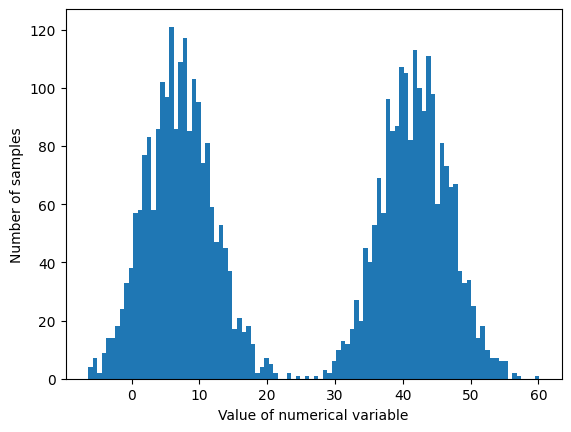

In [8]:
plt.hist(valueCollection, bins=100)
plt.ylabel("Number of samples")
plt.xlabel("Value of numerical variable")
plt.show()

In [9]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < sanityCheckModel.json > /tmp/sanityCheckModel.bin
with open("/tmp/sanityCheckModel.bin", "rb") as file:
    perfectModel = interface_capnp.RuleModel.read(file)
perfectModel

<interface.capnp:RuleModel reader (rules = [(condition = (elements = [(atomicCondition = (variable = "cat", categoricalValueCondition = (value = "red")))]), updateRule = (variable = "num", valueRule = (constant = 42))), (condition = (elements = [(atomicCondition = (variable = "cat", categoricalValueCondition = (value = "green")))]), updateRule = (variable = "num", valueRule = (constant = 7)))], variables = [(name = "cat", categorical = (domain = ["red", "yellow", "green"])), (name = "num", numerical = void)])>

In [10]:
scorePromise = processDataUpdates.calculateMdlScore(log=log, model=nullModel)
score = scorePromise.wait().result
score

38667.51970493875

In [11]:
scorePromise = processDataUpdates.calculateMdlScore(log=log, model=perfectModel)
score = scorePromise.wait().result
score

34829.095889105694

# Score development

In [12]:
from scoredevelopment import visualizeScoreDevelopment

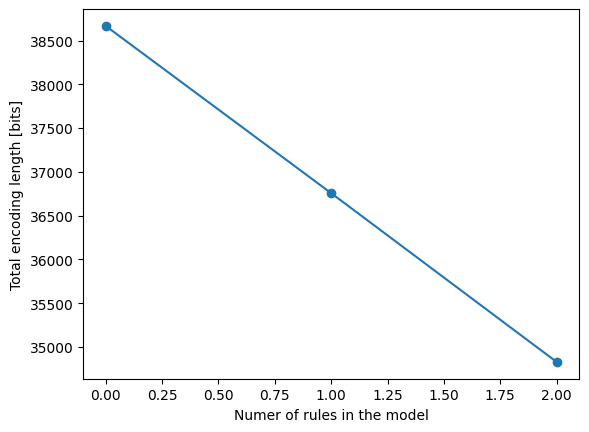

In [13]:
visualizeScoreDevelopment("sanityCheckModel", log, interface_capnp)

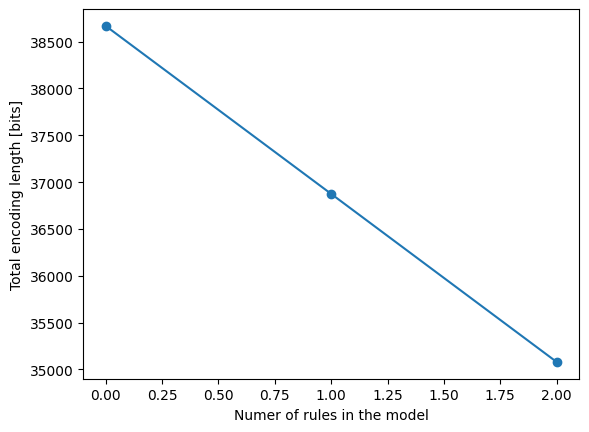

In [15]:
visualizeScoreDevelopment("sanityCheckModelReverse", log, interface_capnp)